In [1]:
from Game import *
from Game.minimax import *
from tqdm import tqdm

Version:  0.3.04


## TTT

In [2]:
def initial_state():
    return Board(3,3)

def count_pieces(state):
    count=0
    for location in range(9):
        if state[location]!=0:
            count=count+1
            
    return count

def row(state,location):
    r,c=state.rc_from_index(location)
    return r
def col(state,location):
    r,c=state.rc_from_index(location)
    return c

def valid_moves(state,player):
    
    moves=[]
    
    if count_pieces(state)<9:  # placement - temporaily set to 9 to behave like ttt
        # placement
        for location in range(9): 
            if state[location]==0:
                moves.append(location)
    else:
        # sliding
        for start in range(9):
            if state[start]!=player:
                continue

            rs,cs=row(state,start),col(state,start)

            for location in range(9):
                end=None

                r,c=row(state,location),col(state,location)

                if state[location]==0:

                    if r-rs==1 and c-cs==0:  # vertical
                        end=location
                    if r-rs==-1 and c-cs==0:  # vertical
                        end=location
                    if r-rs==0 and c-cs==1:  # horizontal
                        end=location
                    if r-rs==0 and c-cs==-1:  # horizontal
                        end=location
                    if r-rs==1 and c-cs==1:  # diagonal
                        end=location
                    if r-rs==-1 and c-cs==-1:  # diagonal
                        end=location
                    if r-rs==1 and c-cs==-1:  # diagonal
                        end=location
                    if r-rs==-1 and c-cs==1:  # diagonal
                        end=location

                    if not end is None:
                        moves.append([start,end])
                pass

        
    return moves
    
    
def update_state(state,player,move):
    if isinstance(move,int):  # placement
        new_state=state
        new_state[move]=player
        
    else:  # sliding
        start,end=move
        new_state=state
        new_state[start]=0
        new_state[end]=player
        
    return new_state

def win_status(state,player):
    # 0  1  2 
    # 3  4  5 
    # 6  7  8 

    if player==1:
        other_player=2
    else:
        other_player=1
    
    if state[0]==state[1]==state[2]==player:
        return "win"
    if state[3]==state[4]==state[5]==player:
        return "win"
    if state[6]==state[7]==state[8]==player:
        return "win"
    if state[0]==state[3]==state[6]==player:
        return "win"
    if state[1]==state[4]==state[7]==player:
        return "win"
    if state[2]==state[5]==state[8]==player:
        return "win"
    if state[0]==state[4]==state[8]==player:
        return "win"
    if state[6]==state[4]==state[2]==player:
        return "win"
    
    if not valid_moves(state,other_player):
        return "stalemate"
    
    return None

def show_state(state,player):
    print(state)

## Agents

In [3]:
def random_move(state,player):    
    moves=valid_moves(state,player)
    return random.choice(moves)

random_agent=Agent(random_move)

def human_move(state,player):
    print("Player ", player)
    valid_move=False
    while not valid_move:
        move=int(input('What is your move? '))

        if move in valid_moves(state,player):
            valid_move=True
        else:
            print("Illegal move.")

    return move
human_agent=Agent(human_move)


## Q Agent

In [4]:
def Q_move(state,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ
    
    if state not in Q:
        actions=valid_moves(state,player)
        Q[state]=Table()
        for action in actions:
            Q[state][action]=0  # initial value of table
    
    if learning:
        if random.random()<ϵ:  # take a random move occasionally to explore the environment
            move=random_move(state,player)
        else:
            move=top_choice(Q[state])
    else:
        move=top_choice(Q[state])
    
    if not last_action is None:  # not the first move
        reward=0
        
        # learn
        if learning:
            Q[last_state][last_action]+=α*(reward +
                        γ*max([Q[state][a] for a in Q[state]]) - Q[last_state][last_action])
    
    return move

In [5]:
def Q_after(status,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ

    if status=='lose':
        reward=-1
    elif status=='win':
        reward=1
    elif status=='stalemate':
        reward=.5 # value stalemate a little closer to a win
    else:
        reward=0
    
    
    if learning:
        Q[last_state][last_action]+=α*(reward - Q[last_state][last_action])
        


In [6]:
Q1_agent=Agent(Q_move)
Q1_agent.post=Q_after
Q1_agent.Q=Table()  # makes an empty table
Q1_agent.learning=True

Q1_agent.α=0.4  # learning rate
Q1_agent.ϵ=0.5  # how often to take a random move
Q1_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

In [7]:
Q2_agent=Agent(Q_move)
Q2_agent.post=Q_after
Q2_agent.Q=Table()  # makes an empty table
Q2_agent.learning=True

Q2_agent.α=0.4  # learning rate
Q2_agent.ϵ=0.5  # how often to take a random move
Q2_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

## Training

In [8]:
agent1=Q1_agent
agent1.Q=Table()
agent2=Q2_agent
agent2.Q=Table()

In [9]:
S=Storage()
one,two,ties,N=0,0,0,0

In [10]:
N_test=100
N_train=100

In [11]:
for i in tqdm(range(2000)):
    Q1_agent.learning=True
    Q2_agent.learning=True
    g=Game(number_of_games=N_train)
    g.display=False
    result=g.run(agent1,agent2)

    
    Q1_agent.learning=False
    Q2_agent.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(agent1,agent2)
    one,two,ties,N=one+result.count(1),two+result.count(2),ties+result.count(0),N+len(result)
    
    S+=one/N*100,two/N*100,ties/N*100,N


100%|█████████████████████████████████████████████████████████████| 2000/2000 [03:38<00:00,  9.17it/s]


## Progress

In [12]:
y1,y2,y0,x=S.arrays()

In [13]:
%matplotlib inline
from matplotlib.pyplot import figure,plot,grid,legend,xlabel,ylabel,title

Text(0, 0.5, 'Percent')

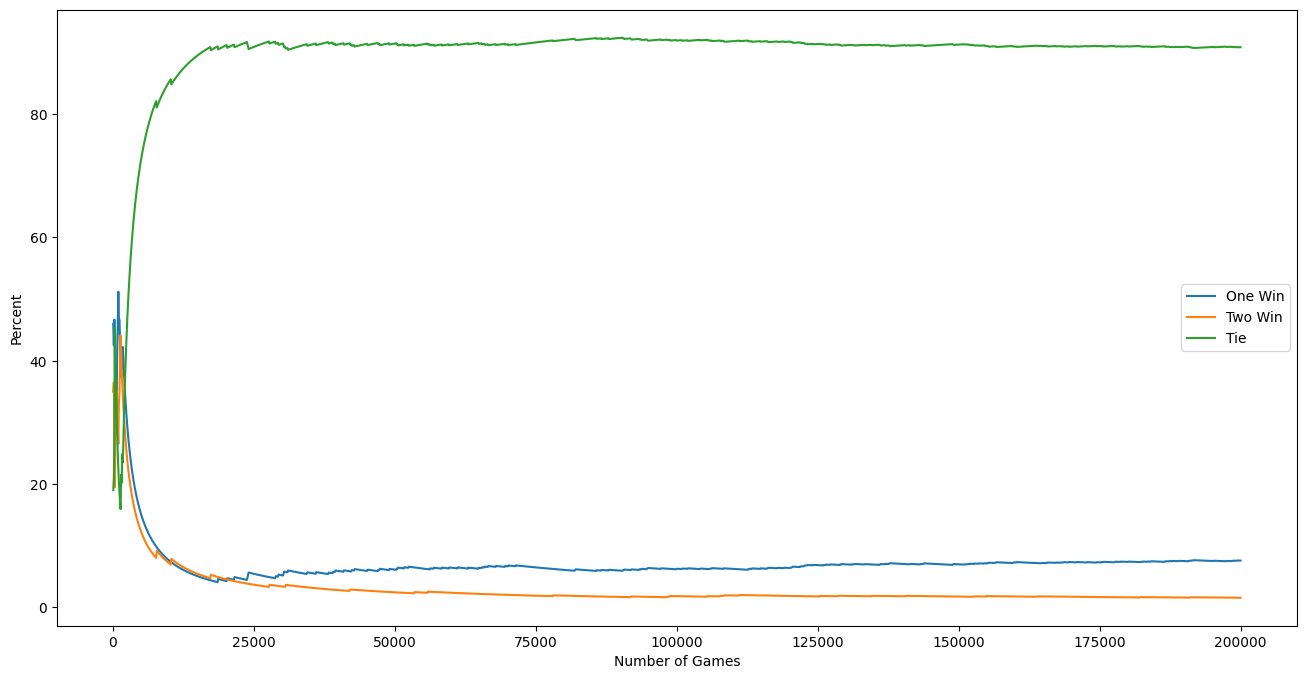

In [14]:
figure(figsize=(16,8))
plot(x,y1,label='One Win')
plot(x,y2,label='Two Win')
plot(x,y0,label='Tie')
legend()
xlabel('Number of Games')
ylabel('Percent')

In [16]:
SaveTable(Q1_agent.Q,'2024-10-15 TTT Q1 Table.json')
SaveTable(Q2_agent.Q,'2024-10-15 TTT Q2 Table.json')